In [48]:
import pandas as pd
import numpy as np
import random

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split

from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import os

In [49]:
train = pd.read_csv("../03-data-creation/train_FE_final.csv")
test = pd.read_csv("../03-data-creation/test_FE_final.csv")

# Drop unwanted column
train = train.drop("Unnamed: 0", axis = 1)
test = test.drop("Unnamed: 0", axis = 1)

# We won't touch test until predicting for submission

# We don't want the ID to be used in the model so preserve
train_id = train['id']
test_id = test['id']

train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

# Split X and y
X = train.loc[:, train.columns != "satisfied"]
y = train.satisfied

In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 3096)

In [51]:
# Fit model - default params
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
print(); print(model)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [52]:
# Predict
expected_y = y_test
predicted_y = model.predict(X_test)

# Summarize model fit
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))
print(); print(metrics.roc_auc_score(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4291
           1       0.81      0.83      0.82      4733

    accuracy                           0.81      9024
   macro avg       0.81      0.81      0.81      9024
weighted avg       0.81      0.81      0.81      9024


[[3398  893]
 [ 818 3915]]

0.8095304649302835


Hyperparameter tuning:

In [53]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt'], 
    'n_estimators': list(range(50,2000)),
    'num_leaves': list(range(20, 100)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'objective': ['binary'],
    'metric': ['auc'],
    'is_unbalance': [False]
}

In [54]:
rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 30,
                             verbose = 10,
                             cv = 3,
                             n_jobs = -1,
                             scoring = 'roc_auc')

rsearch.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                                      0.6161616161616161,
                                                   

In [55]:
print(rsearch.best_params_)

{'subsample_for_bin': 200000, 'subsample': 0.5707070707070707, 'reg_lambda': 0.8163265306122448, 'reg_alpha': 0.24489795918367346, 'objective': 'binary', 'num_leaves': 46, 'n_estimators': 1189, 'min_child_samples': 195, 'metric': 'auc', 'learning_rate': 0.00635439354601029, 'is_unbalance': False, 'colsample_bytree': 0.7777777777777778, 'boosting_type': 'gbdt'}


In [56]:
#Prediction
y_pred = rsearch.predict(X_test)

#auc calculation
metrics.roc_auc_score(y_test,y_pred)

0.8111694921288043

Text(0, 0.5, 'Feature Importance Score')

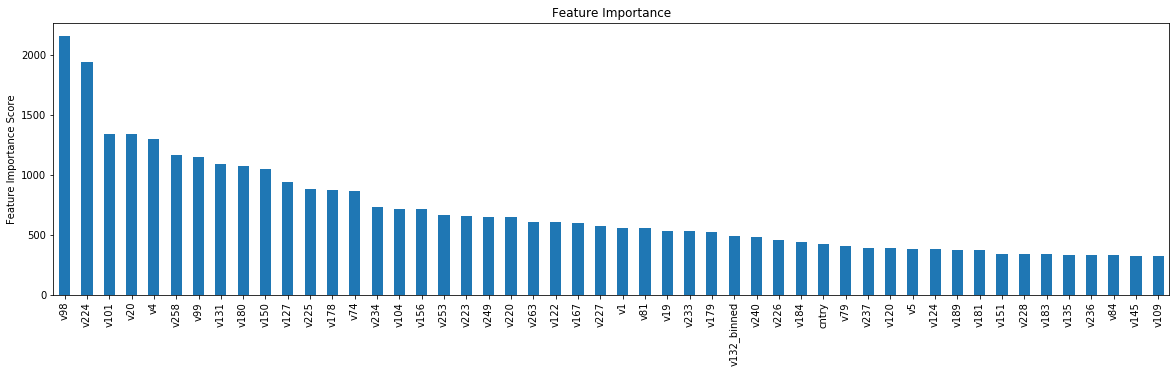

In [57]:
# Feature importance for top 50 predictors
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(rsearch.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

## Output to stacking predictions folder:

In [ ]:
train_label = train['satisfied']
del train['satisfied']

# Two sets of predictions: one on the training set (which we can use as a feature), one on the test set 
train_new = train.copy()
test_new = test.copy()

train_preds = pd.DataFrame(rsearch.predict_proba(train_new))
test_preds = pd.DataFrame(rsearch.predict_proba(test_new))

train_new['Predicted_LGBM'] = train_preds[1]
test_new['Predicted_LGBM'] = test_preds[1]

train_new['id'] = train_id
test_new['id'] = test_id

train_new[['id', 'Predicted_LGBM']].to_csv('/Users/sabrinatan/Desktop/STAT 441/stat441-W20-project/04-modeling/stacking_predictions/train_fe_data_Final_LGBM_no_rounding.csv', index = False, float_format = "%.8f")
test_new[['id', 'Predicted_LGBM']].to_csv('/Users/sabrinatan/Desktop/STAT 441/stat441-W20-project/04-modeling/stacking_predictions/test_fe_data_Final_LGBM_no_rounding.csv', index = False, float_format = "%.8f")